# Regridding in cf-python

### Quick reference: [dedicated regridding documentation section](https://ncas-cms.github.io/cf-python/analysis.html#regridding).

***

### Metadata-aware regridding based on the [ESMPy interface](https://earthsystemcog.org/projects/esmpy/) to the regridding component of the [Earth System Modeling Framework (ESMF) library](https://www.earthsystemcog.org/projects/esmf/). Features:

* regridding across **spherical (``regrids``) or cartesian (``regridc``) coordinate systems**, including (for the former) **grids with 2D latitudes and longitudes** such as curvilinear, rotated pole and some tripolar grids;

* choice from **numerous regridding methods**:
    * **conservative (to first- or second- order)**: conserves integral of field with respect to area;
    * **linear**: applies linear interpolation;
    * **higher-order patch recovery**: calculates a second-order polynomial giving better derivatives;
    * **nearest source to destination**: a variant of nearest neighbour interpolation useful for integer fields such as land use;
    * **nearest destination to source**: other variant of nearest neighbour interpolation where multiple source points can contribute to one destination point.

* support for **global or regional source/destination grids in any combination**;

* in-built **handling of masking** of both source and destination grids.

#### Note: ``grid == domain``

"Grid" is a standrd term within the Earth Science field, but in the CF data model and cf-python, the *grid* is more commonly referred to as the *domain*.

***

(First do the standard setup:)

In [2]:
# Inline images in IPython Notebook - not needed in Python
%matplotlib inline

# Turn off warnings - also not needed in Python
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the cf and cfplot packages
import cf
import cfplot as cfp

***

## Spherical regridding (`regrids` method)
#### `regrids` = `regrid` + `s` for spherical
#### Detailed [API reference for the method found here](https://ncas-cms.github.io/cf-python/method/cf.Field.regrids.html#cf.Field.regrids)

### Example 1: conservative regridding

Read in two fields, ``f1`` and ``g1``, where ``f1`` is gridded at about twice the resolution of ``g1``:

In [3]:
# Read in a precipitation field and inspect it
f1 = cf.read('ncas_data/precip_2010.nc')[0]
print(f1)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(12), latitude(145), longitude(53)) mm
Dimension coords: long_name=time(12) = [2010-01-16 00:00:00, ..., 2010-12-16 00:00:00] gregorian
                : latitude(145) = [-90.0, ..., 90.0] degrees_north
                : longitude(53) = [-33.75, ..., 63.75] degrees_east


In [4]:
# Read in another, lower-resolution, precipitation field and inspect it
g1 = cf.read('ncas_data/model_precip_DJF_means_low_res.nc')[0]
print(g1)

Field: long_name=precipitation (ncvar%precip)
---------------------------------------------
Data            : long_name=precipitation(long_name=t(1), long_name=Surface(1), latitude(73), longitude(27)) mm/day
Cell methods    : long_name=t(1): mean
Dimension coords: long_name=t(1) = [1996-07-16 00:00:00] 360_day
                : long_name=Surface(1) = [0.0] level
                : latitude(73) = [-90.0, ..., 90.0] degrees_north
                : longitude(27) = [-33.75, ..., 63.75] degrees_east


In [5]:
# Regrid the first field to the grid of the second and inspect the results
h1 = f1.regrids(g1, method='conservative')
print(h1)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(12), latitude(73), longitude(27)) mm
Dimension coords: long_name=time(12) = [2010-01-16 00:00:00, ..., 2010-12-16 00:00:00] gregorian
                : latitude(73) = [-90.0, ..., 90.0] degrees_north
                : longitude(27) = [-33.75, ..., 63.75] degrees_east


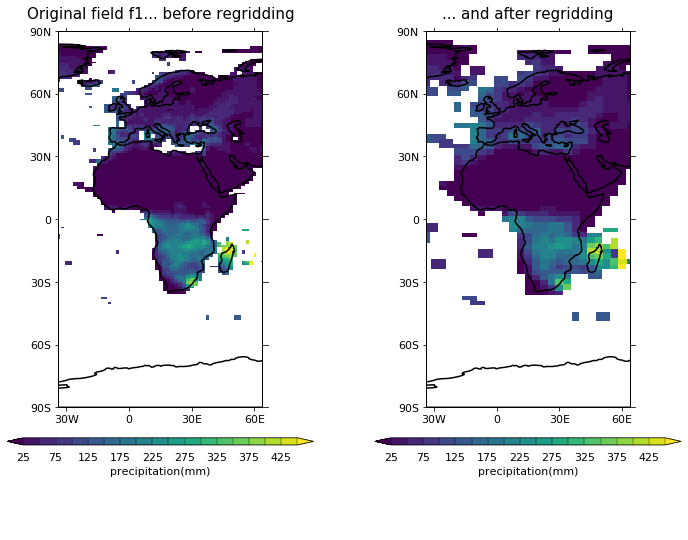

In [6]:
# Plot before and after
cfp.gopen(rows=1, columns=2)
cfp.gpos(1)
cfp.con(f1[0], blockfill=True, lines=False, colorbar_label_skip=2,
        title='Original field f1... before regridding')
cfp.gpos(2)
cfp.con(h1[0], blockfill=True, lines=False, colorbar_label_skip=2,
        title='... and after regridding')
cfp.gclose()

As we expect, the regridded field resembles the original in its nature, but is at lower-resolution due to its new grid.

### Example 2: regridding from a tripolar grid

A tripolar grid (often used in ocean models to reduce difficulties relating to the poles of other grids):
![alt text](https://www.gfdl.noaa.gov/wp-content/uploads/pix/user_images/mw/bipolar.gif "Tripolar Grid")

As in the previous example, read in two fields, ``f2`` and ``g2``. This time, ``f2`` has a tripolar domain i.e. grid:

In [7]:
# Read in and inspect a sea surface height field contained on a tripolar grid
f2 = cf.read('ncas_data/tripolar.nc')[0]
print(f2)

Field: sea_surface_height_above_geoid (ncvar%sossheig)
------------------------------------------------------
Data            : sea_surface_height_above_geoid(time(1), ncdim%y(332), ncdim%x(362)) m
Cell methods    : time(1): mean (interval: 2700 s)
Dimension coords: time(1) = [1978-09-06 00:00:00] 360_day
Auxiliary coords: time(time(1)) = [1978-09-06 00:00:00] 360_day
                : longitude(ncdim%y(332), ncdim%x(362)) = [[72.5, ..., 72.98915100097656]] degrees_east
                : latitude(ncdim%y(332), ncdim%x(362)) = [[-84.21070861816406, ..., 50.01094055175781]] degrees_north


In [8]:
# Read in a field (precipitation, but not relevant) defined on a regular lat-long grid
g2 = cf.read('ncas_data/model_precip_DJF_means.nc')[0]
print(g2)

Field: long_name=precipitation (ncvar%precip)
---------------------------------------------
Data            : long_name=precipitation(long_name=t(1), long_name=Surface(1), latitude(145), longitude(192)) mm/day
Cell methods    : long_name=t(1): mean
Dimension coords: long_name=t(1) = [1996-07-16 00:00:00] 360_day
                : long_name=Surface(1) = [0.0] level
                : latitude(145) = [-90.0, ..., 90.0] degrees_north
                : longitude(192) = [0.0, ..., 358.125] degrees_east


In [9]:
# Regrid the field on the tripolar grid to the regular lat-long grid
h2 = f2.regrids(g2, method='bilinear', src_axes={'X': 'ncdim%x', 'Y': 'ncdim%y'},
                src_cyclic=True)
print(h2)

Field: sea_surface_height_above_geoid (ncvar%sossheig)
------------------------------------------------------
Data            : sea_surface_height_above_geoid(time(1), latitude(145), longitude(192)) m
Cell methods    : time(1): mean (interval: 2700 s)
Dimension coords: time(1) = [1978-09-06 00:00:00] 360_day
                : latitude(145) = [-90.0, ..., 90.0] degrees_north
                : longitude(192) = [0.0, ..., 358.125] degrees_east
Auxiliary coords: time(time(1)) = [1978-09-06 00:00:00] 360_day


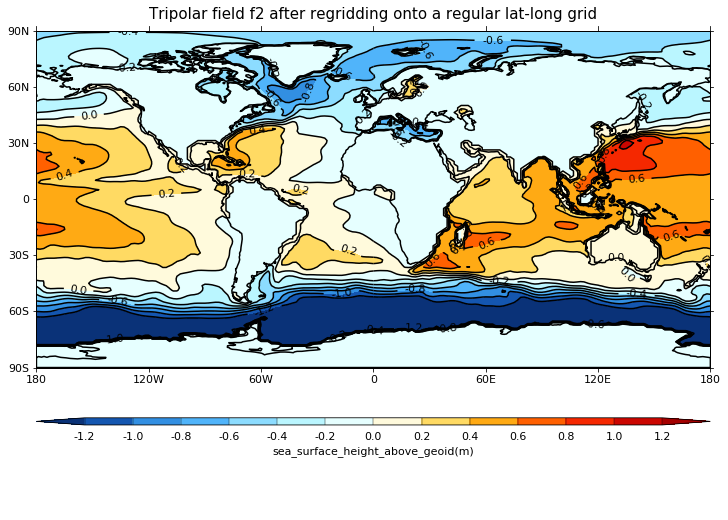

In [10]:
# Plot the regridded data
cfp.levs(min=-1.2, max=1.2, step=0.2)
cfp.con(h2, title='Tripolar field f2 after regridding onto a regular lat-long grid')

### Example 3: comparing results produced by different regridding methods

First read and visualise in a field ``f3``:

In [11]:
# Read in a wind field and inspect it
f3 = cf.read('ncas_data/data5.nc')[0].subspace[0, 0]
print(f3)

Field: eastward_wind (ncvar%U)
------------------------------
Data            : eastward_wind(time(1), pressure(1), latitude(160), longitude(320)) m s**-1
Dimension coords: time(1) = [1987-03-15 00:00:00]
                : pressure(1) = [1000.0] mbar
                : latitude(160) = [89.14151763916016, ..., -89.14151763916016] degrees_north
                : longitude(320) = [0.0, ..., 358.875] degrees_east


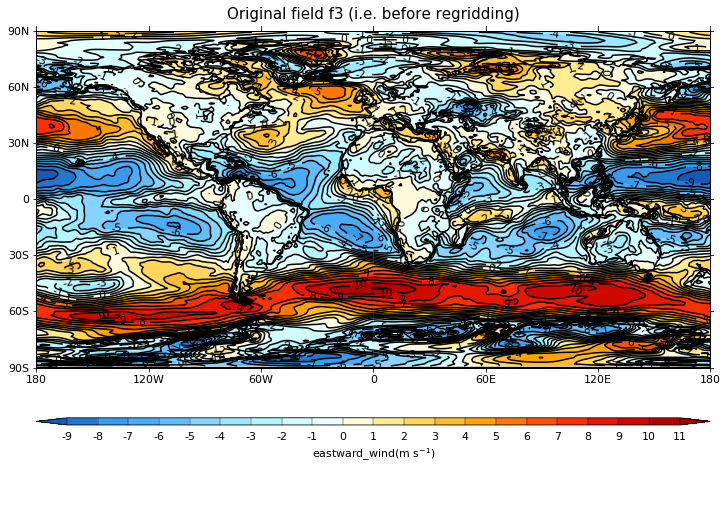

In [12]:
# Visualise this original wind field
cfp.levs()
cfp.cscale()
cfp.con(f3, title='Original field f3 (i.e. before regridding)')

Then read in another field,``g3``, which is gridded at lower resolution to ``f3``:

In [13]:
# Read in another field (precipitation, but the nature is not relevant) and inspect it
g3 = cf.read('ncas_data/model_precip_DJF_means_low_res.nc')[0]
print(g3)

Field: long_name=precipitation (ncvar%precip)
---------------------------------------------
Data            : long_name=precipitation(long_name=t(1), long_name=Surface(1), latitude(73), longitude(27)) mm/day
Cell methods    : long_name=t(1): mean
Dimension coords: long_name=t(1) = [1996-07-16 00:00:00] 360_day
                : long_name=Surface(1) = [0.0] level
                : latitude(73) = [-90.0, ..., 90.0] degrees_north
                : longitude(27) = [-33.75, ..., 63.75] degrees_east


This time we'll regrid using two different methods, so we can compare them:

In [14]:
# Regrid the first field to the grid of the second using bilinear interpolation
h3 = f3.regrids(g3, method='bilinear')
print(h3)

Field: eastward_wind (ncvar%U)
------------------------------
Data            : eastward_wind(time(1), pressure(1), latitude(73), longitude(27)) m s**-1
Dimension coords: time(1) = [1987-03-15 00:00:00]
                : pressure(1) = [1000.0] mbar
                : latitude(73) = [-90.0, ..., 90.0] degrees_north
                : longitude(27) = [-33.75, ..., 63.75] degrees_east


In [15]:
# Regrid the first field to the grid of the second using higher order patch recovery
i3 = f3.regrids(g3, method='patch')
print(i3)

Field: eastward_wind (ncvar%U)
------------------------------
Data            : eastward_wind(time(1), pressure(1), latitude(73), longitude(27)) m s**-1
Dimension coords: time(1) = [1987-03-15 00:00:00]
                : pressure(1) = [1000.0] mbar
                : latitude(73) = [-90.0, ..., 90.0] degrees_north
                : longitude(27) = [-33.75, ..., 63.75] degrees_east


In [16]:
# Find the Y derivatives of the regridded fields
deriv_h = h3.derivative('Y')
deriv_h.units = 'm.s-1.degrees-1'
deriv_i = i3.derivative('Y')
deriv_i.units = 'm.s-1.degrees-1'

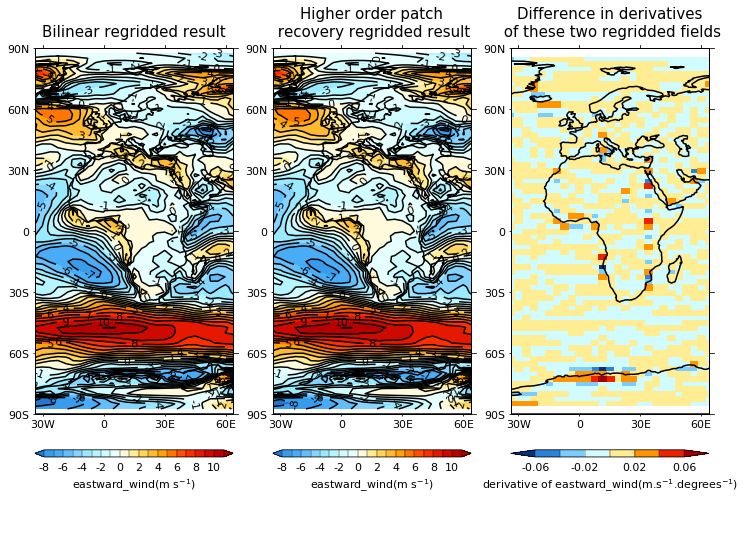

In [17]:
# Plot the regridded fields and the differences between their derivatives
cfp.gopen(rows=1, columns=3)
cfp.gpos(1)
cfp.con(h3, colorbar_label_skip=2, title='Bilinear regridded result')
cfp.gpos(2)
cfp.con(i3, colorbar_label_skip=2,
        title='Higher order patch\n recovery regridded result')
cfp.gpos(3)
cfp.levs(min=-0.06, max=0.06, step=0.02)
cfp.cscale('scale1')
cfp.con(deriv_i - deriv_h, blockfill=True, lines=False, colorbar_label_skip=2,
        title='Difference in derivatives\n of these two regridded fields')
cfp.gclose()

As you can see, the different methods have produced different results, but the variation is only slight: both fields are still very close in nature to the original field & to each other.

### Example 4: the nearest neighbour method applied to integer fields

Read in two fields, ``f4`` and ``g4``, where ``f4`` is gridded at about twice the resolution of ``g4``:

In [18]:
# Read in a region field and inspect it
f4 = cf.read('ncas_data/regions.nc')[0]
print(f4)

Field: region (ncvar%Regionmask)
--------------------------------
Data            : region(latitude(145), longitude(53))
Dimension coords: latitude(145) = [-90.0, ..., 90.0] degrees_north
                : longitude(53) = [-33.75, ..., 63.75] degrees_east


In [19]:
# Read in another field (precipitation, but the nature is not relevant) and inspect it
g4 = cf.read('ncas_data/model_precip_DJF_means_low_res.nc')[0]
print(g4)

Field: long_name=precipitation (ncvar%precip)
---------------------------------------------
Data            : long_name=precipitation(long_name=t(1), long_name=Surface(1), latitude(73), longitude(27)) mm/day
Cell methods    : long_name=t(1): mean
Dimension coords: long_name=t(1) = [1996-07-16 00:00:00] 360_day
                : long_name=Surface(1) = [0.0] level
                : latitude(73) = [-90.0, ..., 90.0] degrees_north
                : longitude(27) = [-33.75, ..., 63.75] degrees_east


In [20]:
# Regrid using nearest source to destination regridding and inspect the result
h4 = f4.regrids(g4, method='nearest_stod')
print(h4)

Field: region (ncvar%Regionmask)
--------------------------------
Data            : region(latitude(73), longitude(27))
Dimension coords: latitude(73) = [-90.0, ..., 90.0] degrees_north
                : longitude(27) = [-33.75, ..., 63.75] degrees_east


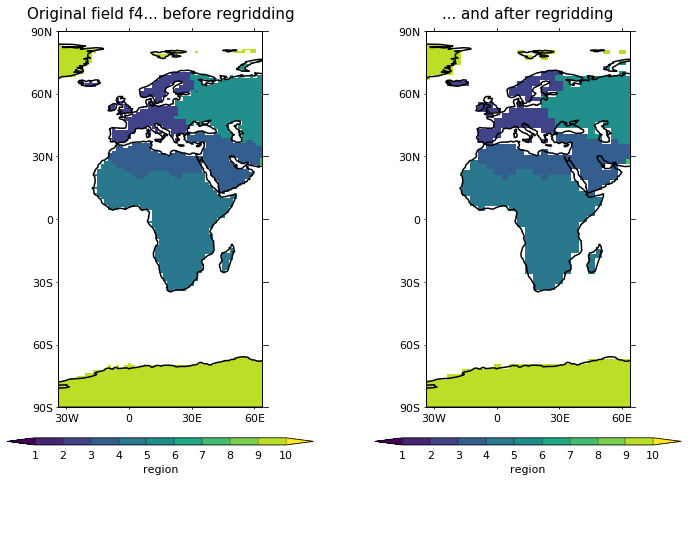

In [21]:
# Plot before and after
cfp.gopen(rows=1, columns=2)
cfp.levs(min=1, max=10, step=1)
cfp.cscale()
cfp.gpos(1)
cfp.con(
    f4, blockfill=True, lines=False, title='Original field f4... before regridding')
cfp.gpos(2)
cfp.con(h4, blockfill=True, lines=False, title='... and after regridding')
cfp.gclose()

We are able to regrid integer fields and as expected, the regridded field resembles the original in its nature, but at lower-resolution due to the new grid (exactly as for the non-integer field of Example 1).

### Example 5: regridding with constructed coordinates

Read in a field, ``f5`` and create custom dimension coordinates as a domain to regrid onto.

In [22]:
# Read in a precipitation field and inspect it
f5 = cf.read('ncas_data/precip_2010.nc')[0]
print(f5)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(12), latitude(145), longitude(53)) mm
Dimension coords: long_name=time(12) = [2010-01-16 00:00:00, ..., 2010-12-16 00:00:00] gregorian
                : latitude(145) = [-90.0, ..., 90.0] degrees_north
                : longitude(53) = [-33.75, ..., 63.75] degrees_east


In [23]:
# Create dimension coordinates for the destination grid
import numpy as np
lon = cf.DimensionCoordinate(data=cf.Data(np.arange(-33, 64, 2.0), 'degrees_east'))
lat = cf.DimensionCoordinate(data=cf.Data(np.arange(-90, 91, 2.0), 'degrees_north'))

In [24]:
# Create Voronoi bounds for the new dimension coordinates
lon_bounds = lon.create_bounds()
lat_bounds = lat.create_bounds(min=-90, max=90)
lon.set_bounds(lon_bounds)
lat.set_bounds(lat_bounds)

In [25]:
# Regrid field onto the grid of the new coordinates conservatively and inspect the result
g5 = f5.regrids({'longitude': lon, 'latitude': lat}, method='conservative')
print(g5)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(12), latitude(91), longitude(49)) mm
Dimension coords: long_name=time(12) = [2010-01-16 00:00:00, ..., 2010-12-16 00:00:00] gregorian
                : latitude(91) = [-90.0, ..., 90.0] degrees_north
                : longitude(49) = [-33.0, ..., 63.0] degrees_east


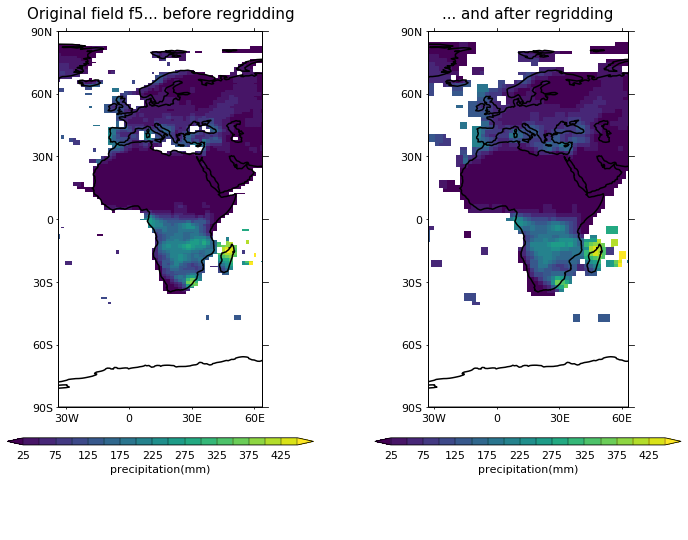

In [26]:
# Plot before and after
cfp.gopen(rows=1, columns=2)
cfp.levs()
cfp.gpos(1)
cfp.con(f5[0], blockfill=True, lines=False, colorbar_label_skip=2,
        title='Original field f5... before regridding')
cfp.gpos(2)
cfp.con(g5[0], blockfill=True, lines=False, colorbar_label_skip=2,
       title='... and after regridding')
cfp.gclose()

We've seen that we are able to regrid onto any custom domain we create, not just domains contained in other fields, as per previous examples.

***

## Cartesian regridding (`regridc` method)
#### `regridc` = `regrid` + `c` for cartesian
#### Detailed [API reference for the method found here](https://ncas-cms.github.io/cf-python/method/cf.Field.regridc.html#cf.Field.regridc)

### Example 6: regridding a time series

The term 'regridding' brings to mind a multi-dimensional grid e.g. over the earth's surface, but a 'grid' is really just a set of points in a multi-dimensional space. In 1D, this is just a series of data points.

Cartesian regridding can be used for 1 to 3 dimensions, so we can use it to "regrid" such a series, and let's use a time series as an example.

Again, start by reading in some fields, in this case ``f6`` and ``g6`` which both have scalar axes except for in the time dimension, hence form a pair of time series with different domains/grids i.e. numbers of time data points:

In [27]:
# Read in a precipitation field and inspect it
f6 = cf.read('ncas_data/precip_1D_yearly.nc')[0]
print(f6)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(10), long_name=latitude(1), long_name=longitude(1)) mm
Cell methods    : long_name=time(10): mean long_name=latitude(1): long_name=longitude(1): mean
Dimension coords: long_name=time(10) = [1981-07-02 00:00:00, ..., 1990-07-02 00:00:00] gregorian
                : long_name=latitude(1) = [0.0] degrees_north
                : long_name=longitude(1) = [0.0] degrees_east


In [28]:
# Read in another precipitation field, with more time axis points, and inspect it
g6 = cf.read('ncas_data/precip_1D_monthly.nc')[0]
print(g6)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(120), long_name=latitude(1), long_name=longitude(1)) mm
Cell methods    : long_name=latitude(1): long_name=longitude(1): mean
Dimension coords: long_name=time(120) = [1981-01-16 00:00:00, ..., 1990-12-16 00:00:00] gregorian
                : long_name=latitude(1) = [0.0] degrees_north
                : long_name=longitude(1) = [0.0] degrees_east


In [29]:
# Regrid linearly along the time axis 'T' and summarise the resulting field
h6 = f6.regridc(g6, axes='T', method='bilinear')
print(h6)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(120), long_name=latitude(1), long_name=longitude(1)) mm
Cell methods    : long_name=time(120): mean long_name=latitude(1): long_name=longitude(1): mean
Dimension coords: long_name=time(120) = [1981-01-16 00:00:00, ..., 1990-12-16 00:00:00] gregorian
                : long_name=latitude(1) = [0.0] degrees_north
                : long_name=longitude(1) = [0.0] degrees_east


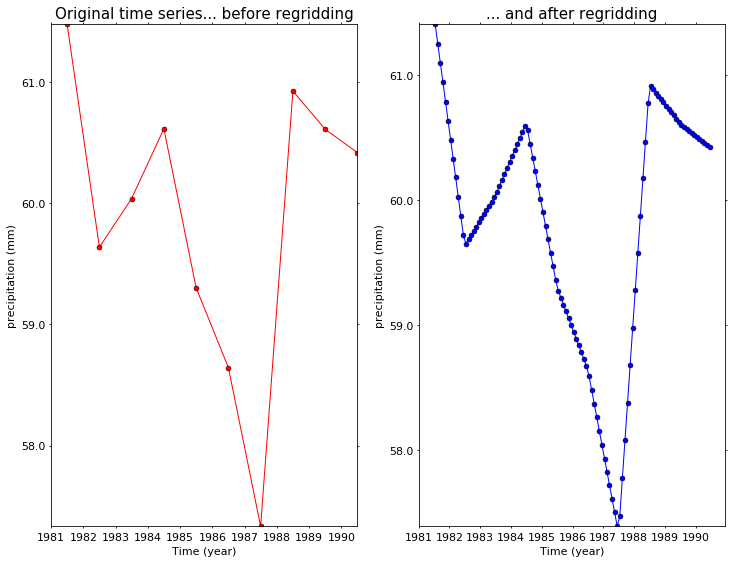

In [30]:
# Plot the time series before and after regridding
cfp.gopen(rows=1, columns=2)
cfp.gpos(1)
cfp.lineplot(f6, marker='o', color='red',
             title='Original time series... before regridding')
cfp.gpos(2)
cfp.lineplot(h6, marker='o', color='blue', title='... and after regridding')
cfp.gclose()

We've seen that regridding can apply not just to multi-dimensional coordinates but to *data series* (which are *1D "grids"*).

As you can see, again the nature of the regridding output is preserved, but the granularity has changed, in this case becoming higher.

### Example 7: vertical regridding

So far we've only looked at horizontal (fixed-height) regridding, so finally let's go through an example of regridding *along a vertical axis*.

Read in two fields, ``f1`` and ``g1``, where ``f1`` is gridded at about twice the resolution of ``g1``:

In [31]:
# Read in a wind field and inspect it
f7 = cf.read('ncas_data/u_n216.nc')[0]
print(f7)

Field: eastward_wind (ncvar%u)
------------------------------
Data            : eastward_wind(long_name=t(1), long_name=Pressure(39), latitude(325), longitude(1)) m s-1
Dimension coords: long_name=t(1) = [1850-01-16 00:00:00] 360_day
                : long_name=Pressure(39) = [1000.0, ..., 0.029999999329447746] mbar
                : latitude(325) = [-90.0, ..., 90.00000762939453] degrees_north
                : longitude(1) = [358.33331298828125] degrees_east


In [32]:
# Read in another, lower-resolution, wind field and inspect it
g7 = cf.read('ncas_data/u_n96.nc')[0]
print(g7)

Field: eastward_wind (ncvar%u)
------------------------------
Data            : eastward_wind(long_name=t(1), air_pressure(19), latitude(145), longitude(1)) m s-1
Dimension coords: long_name=t(1) = [1850-01-16 00:00:00] 360_day
                : air_pressure(19) = [1000, ..., 1] mbar
                : latitude(145) = [-90.0, ..., 90.0] degrees_north
                : longitude(1) = [356.25] degrees_east



<div class="alert alert-block alert-danger">
<b>Warning:</b> if a vertical axis is used, its coordinate values must be <i>transformed</i> so that they <i>vary linearly</i> (with respect to the vertical axis), otherwise the regridding operation by its nature will lead to an inaccurate representation.
</div>

With that in mind, let's linearise our pressure coordinates towards regridding them:

In [33]:
# Save the pressure coordinates and their keys
p_src = f7.coordinate('Z').copy()
p_dst = g7.coordinate('Z').copy()

In [34]:
# Take the log of the pressures
f7.coordinate('Z').log(base=10, inplace=True)
g7.coordinate('Z').log(base=10, inplace=True)

In [35]:
# Regrid the source field and inspect the result
h7 = f7.regridc(g7, axes=('Y', 'Z'), method='bilinear')
print(h7)

Field: eastward_wind (ncvar%u)
------------------------------
Data            : eastward_wind(long_name=t(1), ncdim%air_pressure(19), latitude(145), longitude(1)) m s-1
Dimension coords: long_name=t(1) = [1850-01-16 00:00:00] 360_day
                : ncvar%air_pressure(ncdim%air_pressure(19)) = [6.907755278982137, ..., 0.0] ln(re 100 Pa)
                : latitude(145) = [-90.0, ..., 90.0] degrees_north
                : longitude(1) = [358.33331298828125] degrees_east


In [36]:
# Insert the saved destination pressure coordinate into the regridded field
h7.replace_construct('Z', p_dst)
print(h7)

Field: eastward_wind (ncvar%u)
------------------------------
Data            : eastward_wind(long_name=t(1), air_pressure(19), latitude(145), longitude(1)) m s-1
Dimension coords: long_name=t(1) = [1850-01-16 00:00:00] 360_day
                : air_pressure(19) = [1000, ..., 1] mbar
                : latitude(145) = [-90.0, ..., 90.0] degrees_north
                : longitude(1) = [358.33331298828125] degrees_east


In [37]:
# Reinsert the saved pressure coordinates into the original fields
f7.replace_construct('Z', p_src)
g7.replace_construct('Z', p_dst)

<CF DimensionCoordinate: ncvar%air_pressure(19) ln(re 100 Pa)>

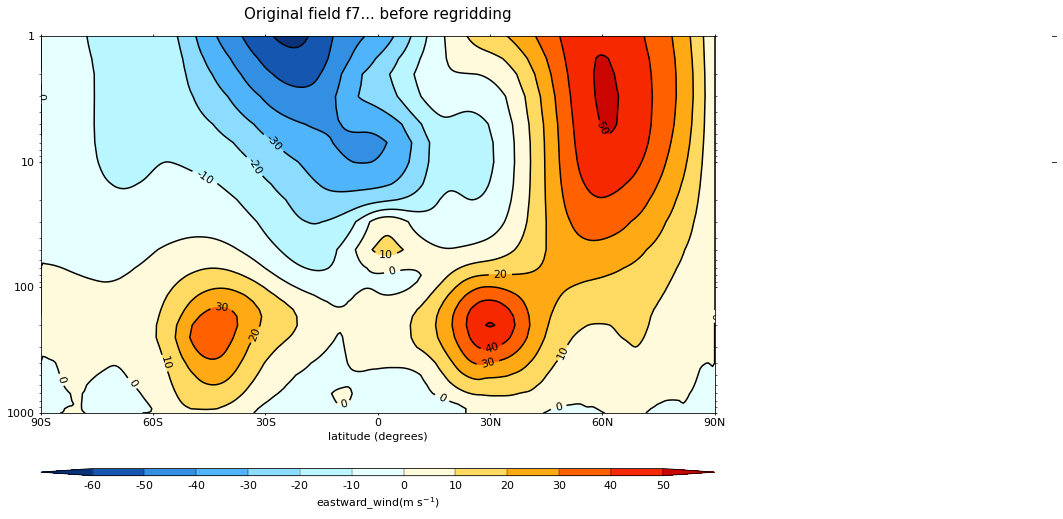

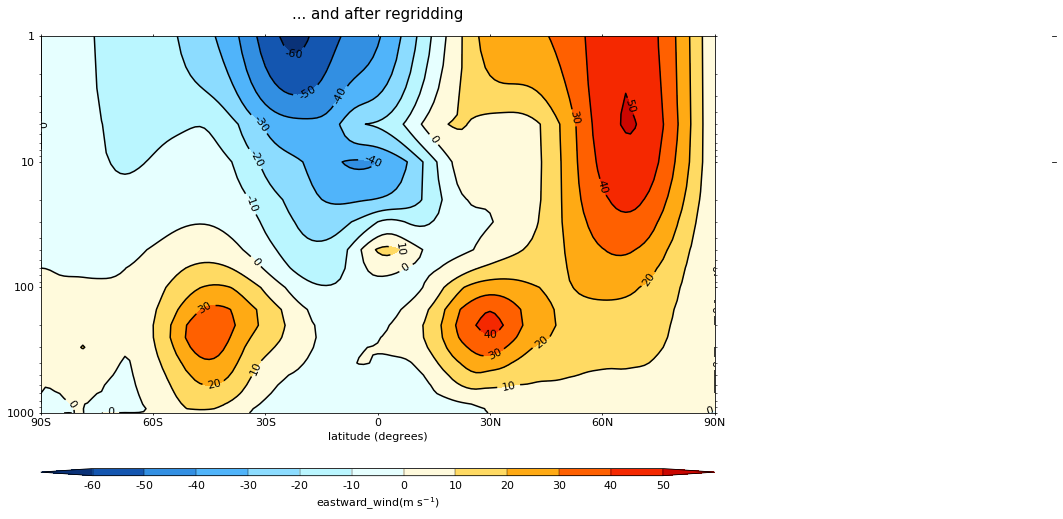

In [38]:
# Plot before and after
cfp.con(f7, title='Original field f7... before regridding', ylog=True)
cfp.con(g7, title='... and after regridding', ylog=True)

We've seen that regridding can be done along a vertical axis, but to do so in a valid and representative way we must first (pre-regridding) transform the relevant data so it varies linearly.

***

### This overview did not cover:

* options for accounting for **cyclicity** of cyclic axes;
* options available when regridding **masked data**;
* certain **other** available:
  * regridding **methods** (e.g. ``nearest_stod``);
  * **domains** for spherical regridding (e.g. using a rotated lat-lon domain i.e. grid);
  * **dimensions** (we did not cover a 3D example).
* **in-place** regridding (just specify ``inplace=True`` to your method).


### For further information, please see:

* the [dedicated regridding section (Analysis -> Regridding) in the documentation](https://ncas-cms.github.io/cf-python/analysis.html#regridding) (also linked at the top);
* or the API reference for [the `regrids`](](https://ncas-cms.github.io/cf-python/method/cf.Field.regrids.html#cf.Field.regrids)) and [the `regridc`](](https://ncas-cms.github.io/cf-python/method/cf.Field.regrids.html#cf.Field.regridc)) methods (also linked under those section headings).

***